# Notebook 2: Model Training & Evaluation

**Objective**: Train and evaluate models across all three temporal phases.

## Contents
1. Setup and data preparation
2. Train models for each phase:
   - Logistic Regression (baseline)
   - Random Forest
   - XGBoost
3. Evaluation using operational metrics:
   - **PR-AUC** (Precision-Recall)
   - **Recall@K** (top 10%, 20%)
   - ROC-AUC (for comparison)
4. Model comparison and selection
5. Feature importance analysis

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.data_loader import load_student_data
from src.feature_groups import get_features_for_phase, get_phase_description
from src.preprocessing import StudentDataPreprocessor
from src.models import create_model, get_model_configs
from src.training import ModelTrainer
from src.evaluation import RetentionEvaluator, compare_models

## 1. Setup & Data Preparation

In [2]:
df = load_student_data()
print(f"Dataset: {df.shape[0]} samples, {df.shape[1]} features")
print(f"Target distribution:\n{df['Target'].value_counts()}")

Dataset loaded successfully: 4424 rows, 37 columns
Dataset: 4424 samples, 37 features
Target distribution:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


In [3]:
# Define phases and models to train
PHASES = ['enrollment', 'semester_1', 'semester_2']
MODELS = ['logistic_regression', 'random_forest', 'xgboost']

print(f"Will train {len(MODELS)} models across {len(PHASES)} phases")
print(f"Total training runs: {len(MODELS) * len(PHASES)}")
print(f"\nModels: {MODELS}")
print(f"Phases: {PHASES}")

Will train 3 models across 3 phases
Total training runs: 9

Models: ['logistic_regression', 'random_forest', 'xgboost']
Phases: ['enrollment', 'semester_1', 'semester_2']


## 2. Training Pipeline

We'll train each model on each phase and store results systematically.

In [5]:
# Storage for results
trained_models = {}
preprocessors = {}
test_sets = {}
training_results = []

print("Starting training pipeline...")

Starting training pipeline...


### Phase A: Enrollment Models

Train models using only enrollment features (available at admission).

In [6]:
PHASE = 'enrollment'
print(f"PHASE: {PHASE.upper()}")
print(f"{'-'*70}")

# Get features for this phase
features = get_features_for_phase(PHASE)
print(f"Features: {len(features)}")

# Preprocess data
preprocessor = StudentDataPreprocessor(scale_features=False)
X, y = preprocessor.fit_transform(df, features, 'Target')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# Store test set and preprocessor
test_sets[PHASE] = (X_test, y_test)
preprocessors[PHASE] = preprocessor

# Train each model
for model_name in MODELS:
    print(f"\n--- Training: {model_name} ---")
    
    model = create_model(model_name)
    trainer = ModelTrainer(model, model_name, PHASE)
    
    # Train with cross-validation
    cv_results = trainer.train_with_validation(X_train, y_train, cv_folds=5, verbose=True)
    
    # Store trained model
    key = f"{model_name}_{PHASE}"
    trained_models[key] = trainer.model
    
    # Save to disk
    trainer.save_model('../models/trained_models/', include_metadata=True)
    preprocessor.save(f'../models/trained_models/{model_name}_{PHASE}_preprocessor.pkl')
    
    # Store results
    cv_results['phase'] = PHASE
    cv_results['model_name'] = model_name
    training_results.append(cv_results)

print(f"\n Enrollment phase training complete")

PHASE: ENROLLMENT
----------------------------------------------------------------------
Features: 24
Train: 3539 samples
Test:  885 samples

--- Training: logistic_regression ---

Training with 5-Fold Cross-Validation
Model: logistic_regression | Phase: ENROLLMENT

Cross-Validation Results:
  Accuracy: 0.5160 (±0.0275)
  ROC-AUC:  0.6598 (±0.0257)
  F1:       0.5259 (±0.0265)
✓ Model trained on full dataset

✓ Model saved: ../models/trained_models/logistic_regression_enrollment.pkl
✓ Metadata saved: ../models/trained_models/logistic_regression_enrollment_metadata.json
Preprocessor saved to ../models/trained_models/logistic_regression_enrollment_preprocessor.pkl

--- Training: random_forest ---

Training with 5-Fold Cross-Validation
Model: random_forest | Phase: ENROLLMENT

Cross-Validation Results:
  Accuracy: 0.6276 (±0.0066)
  ROC-AUC:  0.7736 (±0.0140)
  F1:       0.6278 (±0.0078)
✓ Model trained on full dataset

✓ Model saved: ../models/trained_models/random_forest_enrollment.pkl


### Phase B: Semester 1 Models

Train models using enrollment + semester 1 features.

In [7]:
PHASE = 'semester_1'
print(f"PHASE: {PHASE.upper()}")
print(f"{'-'*70}")

# Get features for this phase
features = get_features_for_phase(PHASE)
print(f"Features: {len(features)}")

# Preprocess data
preprocessor = StudentDataPreprocessor(scale_features=False)
X, y = preprocessor.fit_transform(df, features, 'Target')

# Train/test split (same random state for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# Store test set and preprocessor
test_sets[PHASE] = (X_test, y_test)
preprocessors[PHASE] = preprocessor

# Train each model
for model_name in MODELS:
    print(f"\n--- Training: {model_name} ---")
    
    model = create_model(model_name)
    trainer = ModelTrainer(model, model_name, PHASE)
    
    cv_results = trainer.train_with_validation(X_train, y_train, cv_folds=5, verbose=True)
    
    key = f"{model_name}_{PHASE}"
    trained_models[key] = trainer.model
    
    trainer.save_model('../models/trained_models/', include_metadata=True)
    preprocessor.save(f'../models/trained_models/{model_name}_{PHASE}_preprocessor.pkl')
    
    cv_results['phase'] = PHASE
    cv_results['model_name'] = model_name
    training_results.append(cv_results)

print(f"\nSemester 1 phase training complete")

PHASE: SEMESTER_1
----------------------------------------------------------------------
Features: 30
Train: 3539 samples
Test:  885 samples

--- Training: logistic_regression ---

Training with 5-Fold Cross-Validation
Model: logistic_regression | Phase: SEMESTER_1

Cross-Validation Results:
  Accuracy: 0.6527 (±0.0132)
  ROC-AUC:  0.8096 (±0.0102)
  F1:       0.6637 (±0.0117)
✓ Model trained on full dataset

✓ Model saved: ../models/trained_models/logistic_regression_semester_1.pkl
✓ Metadata saved: ../models/trained_models/logistic_regression_semester_1_metadata.json
Preprocessor saved to ../models/trained_models/logistic_regression_semester_1_preprocessor.pkl

--- Training: random_forest ---

Training with 5-Fold Cross-Validation
Model: random_forest | Phase: SEMESTER_1

Cross-Validation Results:
  Accuracy: 0.7454 (±0.0165)
  ROC-AUC:  0.8617 (±0.0137)
  F1:       0.7455 (±0.0160)
✓ Model trained on full dataset

✓ Model saved: ../models/trained_models/random_forest_semester_1.pkl


### Phase C: Semester 2 Models

Train models using all available features (enrollment + semester 1 + semester 2).

In [8]:
PHASE = 'semester_2'
print(f"PHASE: {PHASE.upper()}")
print(f"{'-'*70}")

# Get features for this phase
features = get_features_for_phase(PHASE)
print(f"Features: {len(features)}")

# Preprocess data
preprocessor = StudentDataPreprocessor(scale_features=False)
X, y = preprocessor.fit_transform(df, features, 'Target')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# Store test set and preprocessor
test_sets[PHASE] = (X_test, y_test)
preprocessors[PHASE] = preprocessor

# Train each model
for model_name in MODELS:
    print(f"\n--- Training: {model_name} ---")
    
    model = create_model(model_name)
    trainer = ModelTrainer(model, model_name, PHASE)
    
    cv_results = trainer.train_with_validation(X_train, y_train, cv_folds=5, verbose=True)
    
    key = f"{model_name}_{PHASE}"
    trained_models[key] = trainer.model
    
    trainer.save_model('../models/trained_models/', include_metadata=True)
    preprocessor.save(f'../models/trained_models/{model_name}_{PHASE}_preprocessor.pkl')
    
    cv_results['phase'] = PHASE
    cv_results['model_name'] = model_name
    training_results.append(cv_results)

print(f"\nSemester 2 phase training complete")

PHASE: SEMESTER_2
----------------------------------------------------------------------
Features: 36
Train: 3539 samples
Test:  885 samples

--- Training: logistic_regression ---

Training with 5-Fold Cross-Validation
Model: logistic_regression | Phase: SEMESTER_2

Cross-Validation Results:
  Accuracy: 0.6895 (±0.0144)
  ROC-AUC:  0.8469 (±0.0127)
  F1:       0.7023 (±0.0134)
✓ Model trained on full dataset

✓ Model saved: ../models/trained_models/logistic_regression_semester_2.pkl
✓ Metadata saved: ../models/trained_models/logistic_regression_semester_2_metadata.json
Preprocessor saved to ../models/trained_models/logistic_regression_semester_2_preprocessor.pkl

--- Training: random_forest ---

Training with 5-Fold Cross-Validation
Model: random_forest | Phase: SEMESTER_2

Cross-Validation Results:
  Accuracy: 0.7615 (±0.0143)
  ROC-AUC:  0.8844 (±0.0104)
  F1:       0.7636 (±0.0136)
✓ Model trained on full dataset

✓ Model saved: ../models/trained_models/random_forest_semester_2.pkl


## 3. Training Results Summary

In [12]:
# Convert results to DataFrame
results_df = pd.DataFrame(training_results)

# Display cross-validation results
print("Cross-Validation Results (All Models & Phases):")
print("-"*80)
display_cols = ['model_name', 'phase', 'val_accuracy', 'val_roc_auc', 'val_f1']
print(results_df[display_cols].to_string(index=False))

# Save results
results_df.to_csv('../models/trained_models/training_results.csv', index=False)
print("\nResults saved to models/trained_models/training_results.csv")

Cross-Validation Results (All Models & Phases):
--------------------------------------------------------------------------------
         model_name      phase  val_accuracy  val_roc_auc   val_f1
logistic_regression enrollment      0.515953     0.659821 0.525910
      random_forest enrollment      0.627576     0.773638 0.627787
            xgboost enrollment      0.657809     0.785786 0.632882
logistic_regression semester_1      0.652722     0.809557 0.663671
      random_forest semester_1      0.745406     0.861720 0.745511
            xgboost semester_1      0.753316     0.871550 0.741288
logistic_regression semester_2      0.689454     0.846912 0.702263
      random_forest semester_2      0.761510     0.884406 0.763635
            xgboost semester_2      0.771687     0.893225 0.761669

Results saved to models/trained_models/training_results.csv


## 4. Comprehensive Evaluation

Now we evaluate using **operational metrics** that matter for retention programs.

In [13]:
evaluation_results = []

print("Starting comprehensive evaluation...")

Starting comprehensive evaluation...


### Evaluate All Models

In [14]:
for phase in PHASES:
    print(f"EVALUATING: {phase.upper()} PHASE")
    print(f"{'-'*70}")
    
    X_test, y_test = test_sets[phase]
    preprocessor = preprocessors[phase]
    class_names = preprocessor.get_target_classes()
    
    # Determine dropout class index
    if 'Dropout' in class_names:
        dropout_idx = class_names.index('Dropout')
    else:
        dropout_idx = 0  # Default assumption
    
    for model_name in MODELS:
        print(f"\n--- Model: {model_name} ---")
        
        key = f"{model_name}_{phase}"
        model = trained_models[key]
        
        # Create evaluator
        evaluator = RetentionEvaluator(model, X_test, y_test, class_names)
        
        # Compute comprehensive metrics
        metrics = evaluator.compute_all_metrics(dropout_class=dropout_idx)
        
        # Compute Recall@K
        recall_10, n_10 = evaluator.recall_at_k(10, dropout_class=dropout_idx)
        recall_20, n_20 = evaluator.recall_at_k(20, dropout_class=dropout_idx)
        
        # Add to metrics
        metrics['recall@10%'] = recall_10
        metrics['recall@20%'] = recall_20
        metrics['n_students@10%'] = n_10
        metrics['n_students@20%'] = n_20
        metrics['model_name'] = model_name
        metrics['phase'] = phase
        
        evaluation_results.append(metrics)
        
        # Print key metrics
        print(f"  Accuracy:    {metrics.get('accuracy', 0):.4f}")
        print(f"  ROC-AUC:     {metrics.get('roc_auc_ovr', 0):.4f}")
        print(f"  PR-AUC:      {metrics.get('pr_auc_dropout', 0):.4f}")
        print(f"  Recall@10%:  {recall_10:.4f} (flag {n_10} students)")
        print(f"  Recall@20%:  {recall_20:.4f} (flag {n_20} students)")

print("\nEvaluation complete")

EVALUATING: ENROLLMENT PHASE
----------------------------------------------------------------------

--- Model: logistic_regression ---
  Accuracy:    0.4802
  ROC-AUC:     0.6482
  PR-AUC:      0.5289
  Recall@10%:  0.1937 (flag 89 students)
  Recall@20%:  0.3732 (flag 177 students)

--- Model: random_forest ---
  Accuracy:    0.5977
  ROC-AUC:     0.7511
  PR-AUC:      0.7044
  Recall@10%:  0.2887 (flag 89 students)
  Recall@20%:  0.4683 (flag 177 students)

--- Model: xgboost ---
  Accuracy:    0.6339
  ROC-AUC:     0.7678
  PR-AUC:      0.7151
  Recall@10%:  0.2817 (flag 89 students)
  Recall@20%:  0.4648 (flag 177 students)
EVALUATING: SEMESTER_1 PHASE
----------------------------------------------------------------------

--- Model: logistic_regression ---
  Accuracy:    0.6373
  ROC-AUC:     0.8119
  PR-AUC:      0.7699
  Recall@10%:  0.2958 (flag 89 students)
  Recall@20%:  0.4965 (flag 177 students)

--- Model: random_forest ---
  Accuracy:    0.7220
  ROC-AUC:     0.8582
  PR

In [15]:
# Convert to DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Save evaluation results
eval_df.to_csv('../models/trained_models/evaluation_results.csv', index=False)
print("Evaluation results saved")

Evaluation results saved


## 5. Model Comparison

Compare models using the metrics that matter most for retention forecasting.

In [16]:
# Create comparison table
comparison_cols = ['model_name', 'phase', 'accuracy', 'roc_auc_ovr', 'pr_auc_dropout', 'recall@10%', 'recall@20%']
comparison_df = eval_df[comparison_cols].copy()

# Round for readability
for col in ['accuracy', 'roc_auc_ovr', 'pr_auc_dropout', 'recall@10%', 'recall@20%']:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].round(4)

print("\nMODEL COMPARISON - ALL PHASES")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


MODEL COMPARISON - ALL PHASES
         model_name      phase  accuracy  roc_auc_ovr  pr_auc_dropout  recall@10%  recall@20%
logistic_regression enrollment    0.4802       0.6482          0.5289      0.1937      0.3732
      random_forest enrollment    0.5977       0.7511          0.7044      0.2887      0.4683
            xgboost enrollment    0.6339       0.7678          0.7151      0.2817      0.4648
logistic_regression semester_1    0.6373       0.8119          0.7699      0.2958      0.4965
      random_forest semester_1    0.7220       0.8582          0.8366      0.3063      0.5458
            xgboost semester_1    0.7288       0.8634          0.8408      0.3099      0.5493
logistic_regression semester_2    0.6949       0.8479          0.8165      0.3028      0.5352
      random_forest semester_2    0.7480       0.8832          0.8700      0.3063      0.5775
            xgboost semester_2    0.7672       0.8934          0.8774      0.3134      0.5704


In [17]:
# Pivot for easier comparison
print("\nPR-AUC by Model and Phase (PRIMARY METRIC):")
pivot_pr = comparison_df.pivot(index='model_name', columns='phase', values='pr_auc_dropout')
pivot_pr = pivot_pr[PHASES]  # Ensure correct column order
print(pivot_pr)

print("\nRecall@10% by Model and Phase:")
pivot_recall = comparison_df.pivot(index='model_name', columns='phase', values='recall@10%')
pivot_recall = pivot_recall[PHASES]
print(pivot_recall)


PR-AUC by Model and Phase (PRIMARY METRIC):
phase                enrollment  semester_1  semester_2
model_name                                             
logistic_regression      0.5289      0.7699      0.8165
random_forest            0.7044      0.8366      0.8700
xgboost                  0.7151      0.8408      0.8774

Recall@10% by Model and Phase:
phase                enrollment  semester_1  semester_2
model_name                                             
logistic_regression      0.1937      0.2958      0.3028
random_forest            0.2887      0.3063      0.3063
xgboost                  0.2817      0.3099      0.3134


### Visualization: Model Performance Across Phases

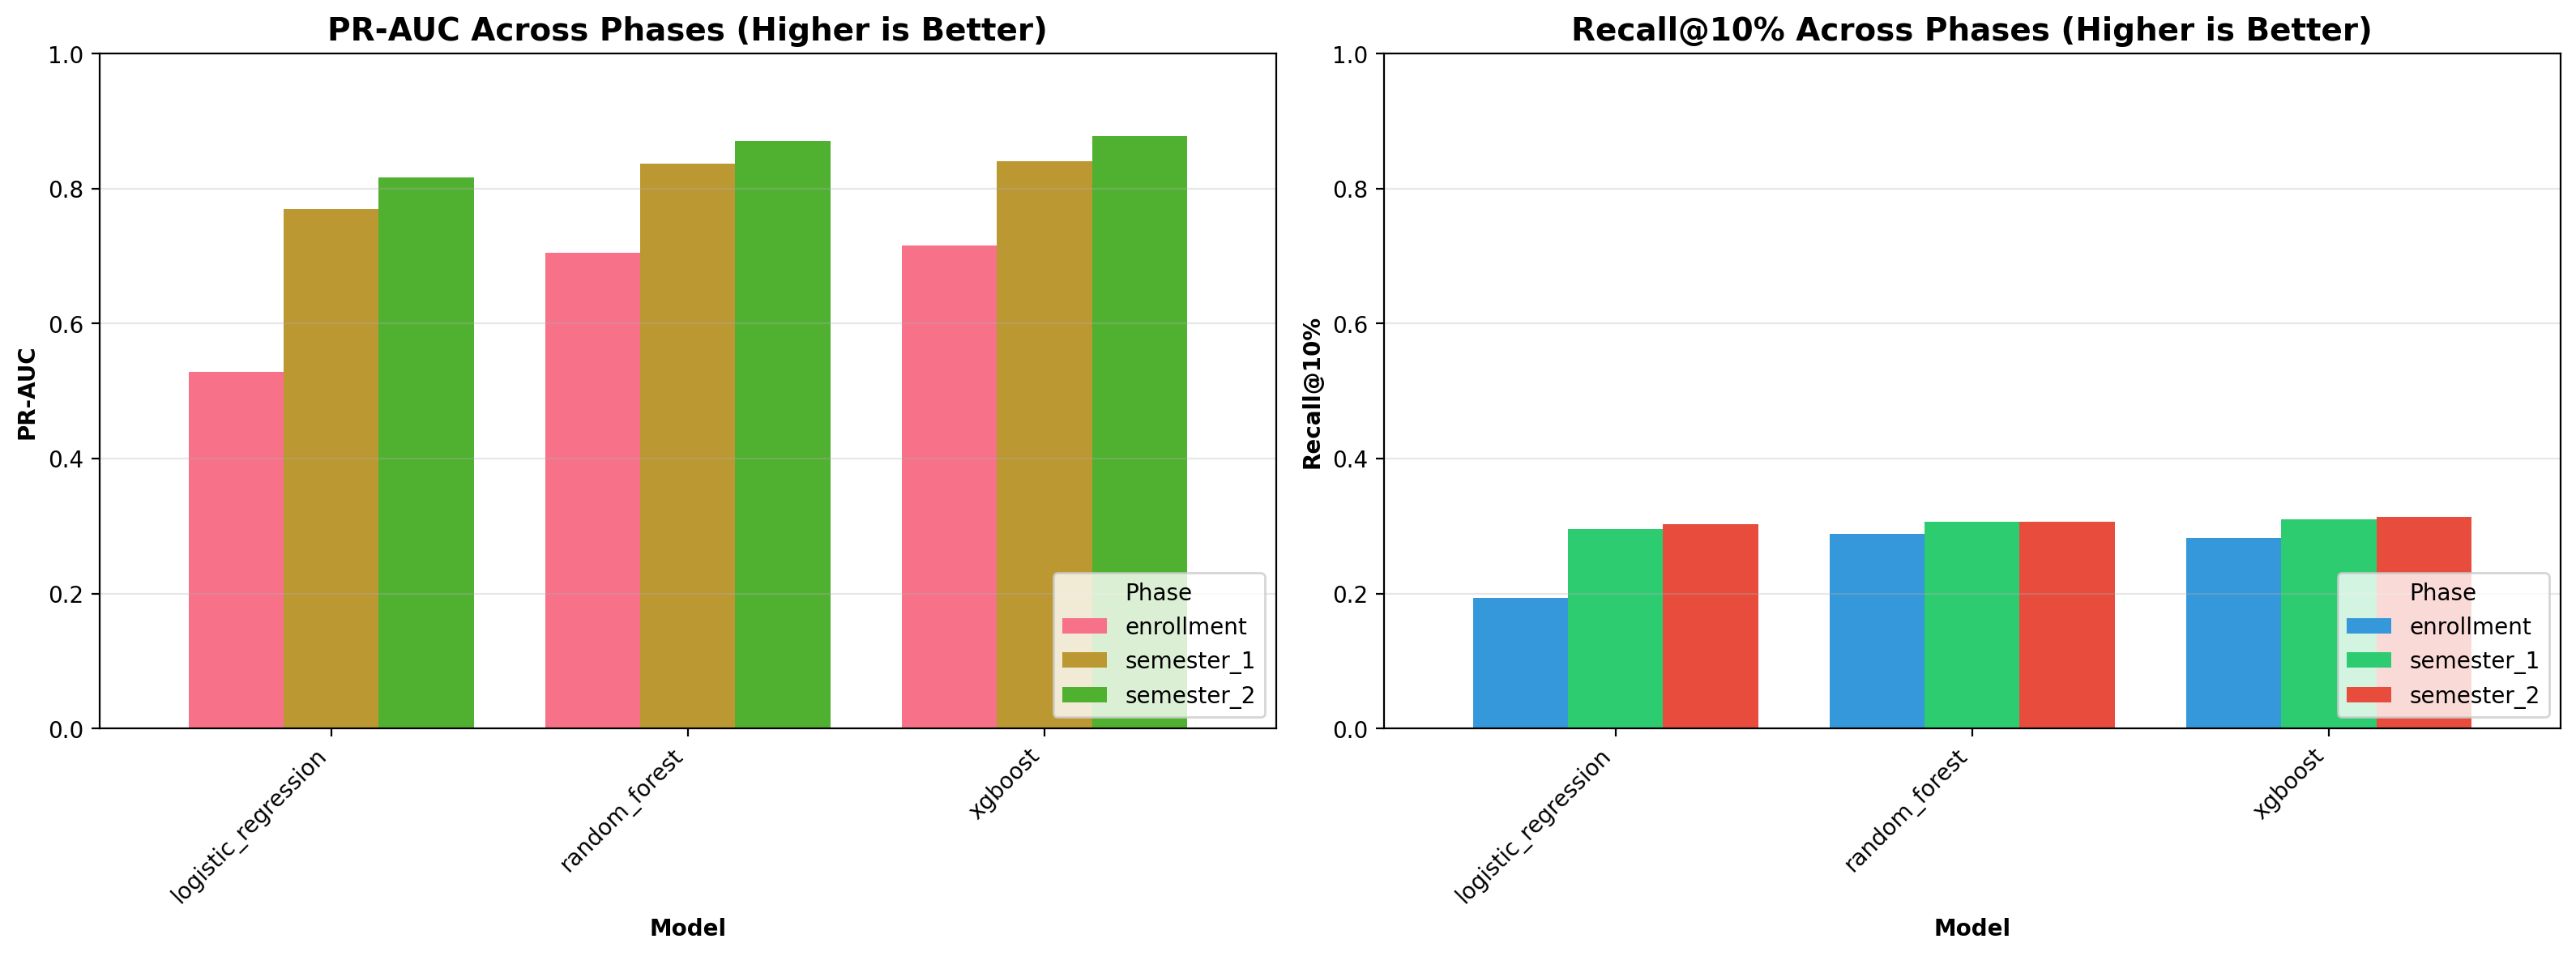

Comparison plot saved


In [19]:
# Plot PR-AUC comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PR-AUC
pivot_pr.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('PR-AUC Across Phases (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('PR-AUC', fontweight='bold')
axes[0].legend(title='Phase', loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1.0)

# Recall@10%
pivot_recall.plot(kind='bar', ax=axes[1], width=0.8, color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_title('Recall@10% Across Phases (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model', fontweight='bold')
axes[1].set_ylabel('Recall@10%', fontweight='bold')
axes[1].legend(title='Phase', loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('../models/trained_models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved")

### Best Model Selection

In [20]:
# Find best model by PR-AUC for each phase
print("\nBEST MODELS BY PHASE (ranked by PR-AUC):")
print("-"*70)

for phase in PHASES:
    phase_results = comparison_df[comparison_df['phase'] == phase].copy()
    phase_results = phase_results.sort_values('pr_auc_dropout', ascending=False)
    
    best = phase_results.iloc[0]
    print(f"\n{phase.upper()}:")
    print(f"  Best Model: {best['model_name']}")
    print(f"  PR-AUC:     {best['pr_auc_dropout']:.4f}")
    print(f"  Recall@10%: {best['recall@10%']:.4f}")
    print(f"  Recall@20%: {best['recall@20%']:.4f}")


BEST MODELS BY PHASE (ranked by PR-AUC):
----------------------------------------------------------------------

ENROLLMENT:
  Best Model: xgboost
  PR-AUC:     0.7151
  Recall@10%: 0.2817
  Recall@20%: 0.4648

SEMESTER_1:
  Best Model: xgboost
  PR-AUC:     0.8408
  Recall@10%: 0.3099
  Recall@20%: 0.5493

SEMESTER_2:
  Best Model: xgboost
  PR-AUC:     0.8774
  Recall@10%: 0.3134
  Recall@20%: 0.5704


## 6. Detailed Evaluation for Best Model

Generate comprehensive evaluation plots for the best enrollment model (most useful for early intervention).

In [21]:
# Select best enrollment model
enrollment_results = comparison_df[comparison_df['phase'] == 'enrollment'].copy()
best_enrollment = enrollment_results.sort_values('pr_auc_dropout', ascending=False).iloc[0]
best_model_name = best_enrollment['model_name']

print(f"Best Enrollment Model: {best_model_name}")
print(f"PR-AUC: {best_enrollment['pr_auc_dropout']:.4f}")

# Get model and test data
key = f"{best_model_name}_enrollment"
best_model = trained_models[key]
X_test, y_test = test_sets['enrollment']
class_names = preprocessors['enrollment'].get_target_classes()
dropout_idx = class_names.index('Dropout') if 'Dropout' in class_names else 0

Best Enrollment Model: xgboost
PR-AUC: 0.7151



Generating detailed evaluation for best enrollment model...
RETENTION FORECASTING EVALUATION REPORT

--- CLASSIFICATION METRICS ---
accuracy                 : 0.6339
f1_weighted              : 0.6130
precision_weighted       : 0.6133
recall_weighted          : 0.6339
roc_auc_ovr              : 0.7678
roc_auc_ovo              : 0.7571
pr_auc_macro             : 0.6017
pr_auc_dropout           : 0.7151

--- RECALL@K (OPERATIONAL METRICS) ---
 k_percent   recall  n_students_flagged intervention_rate
        10 0.281690                  89               10%
        20 0.464789                 177               20%
        30 0.602113                 266               30%

--- DETAILED CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

     Dropout       0.66      0.60      0.62       284
    Enrolled       0.42      0.21      0.28       159
    Graduate       0.65      0.81      0.72       442

    accuracy                           0.63       885
   macro av

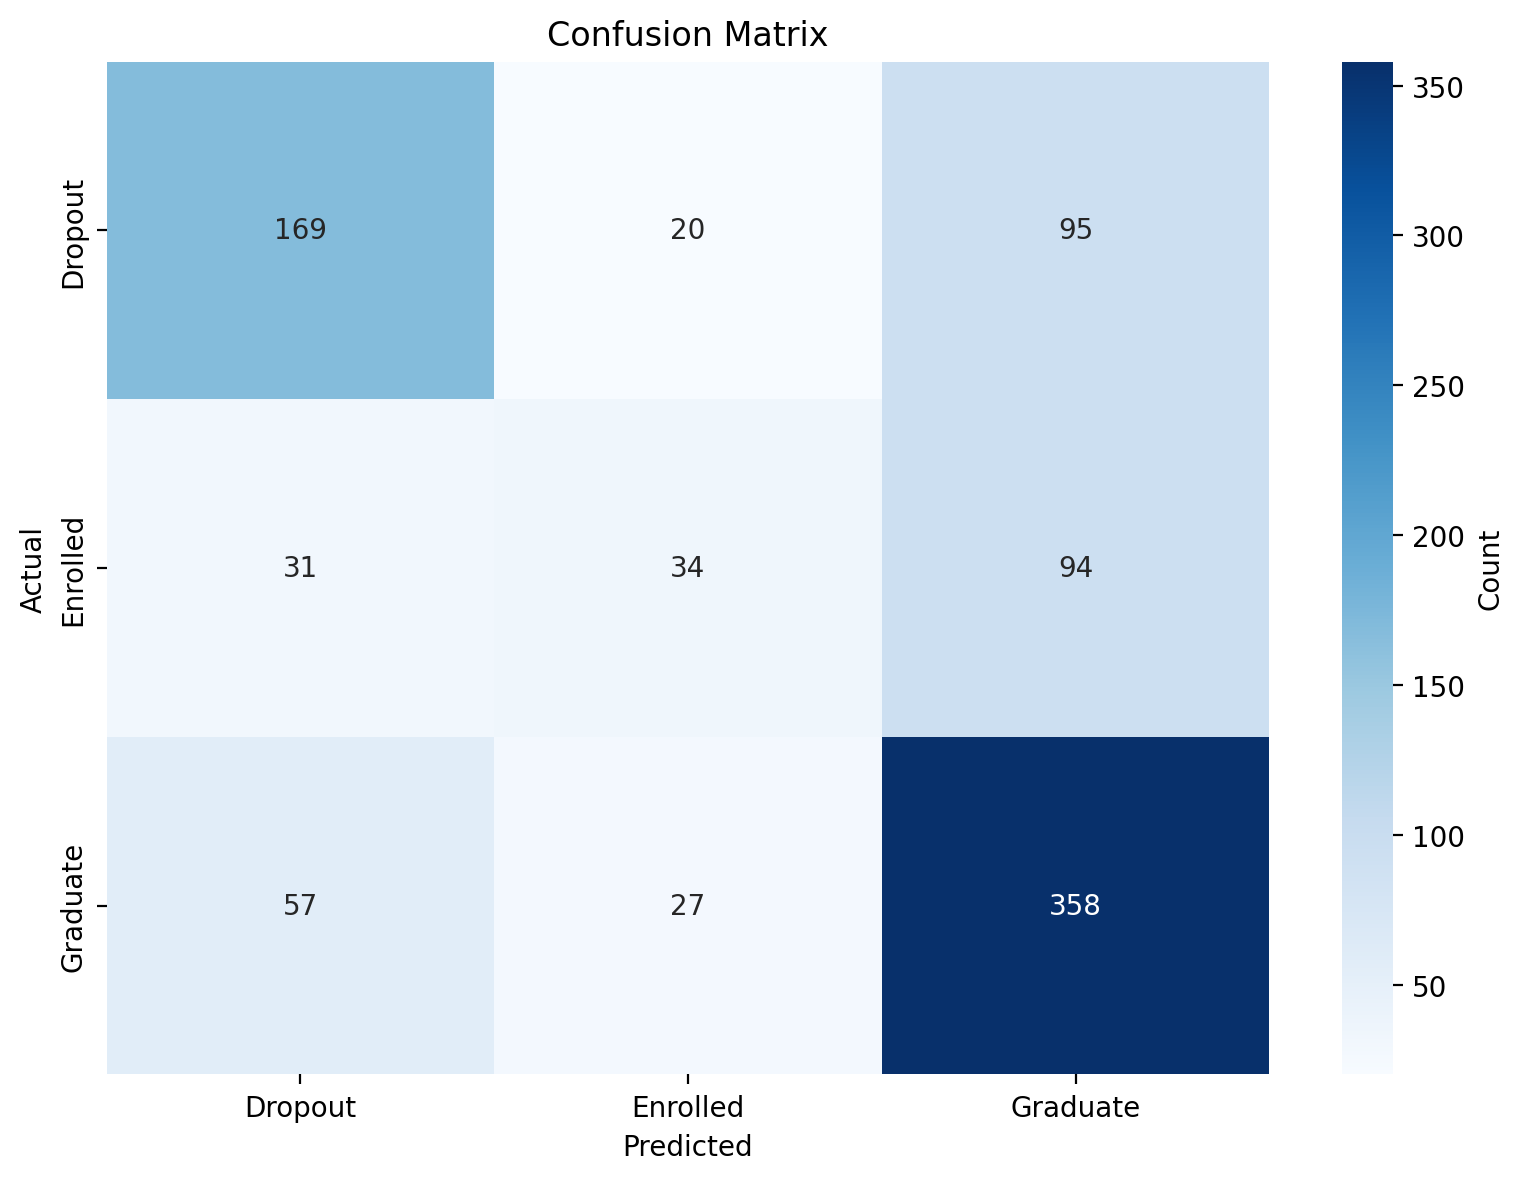

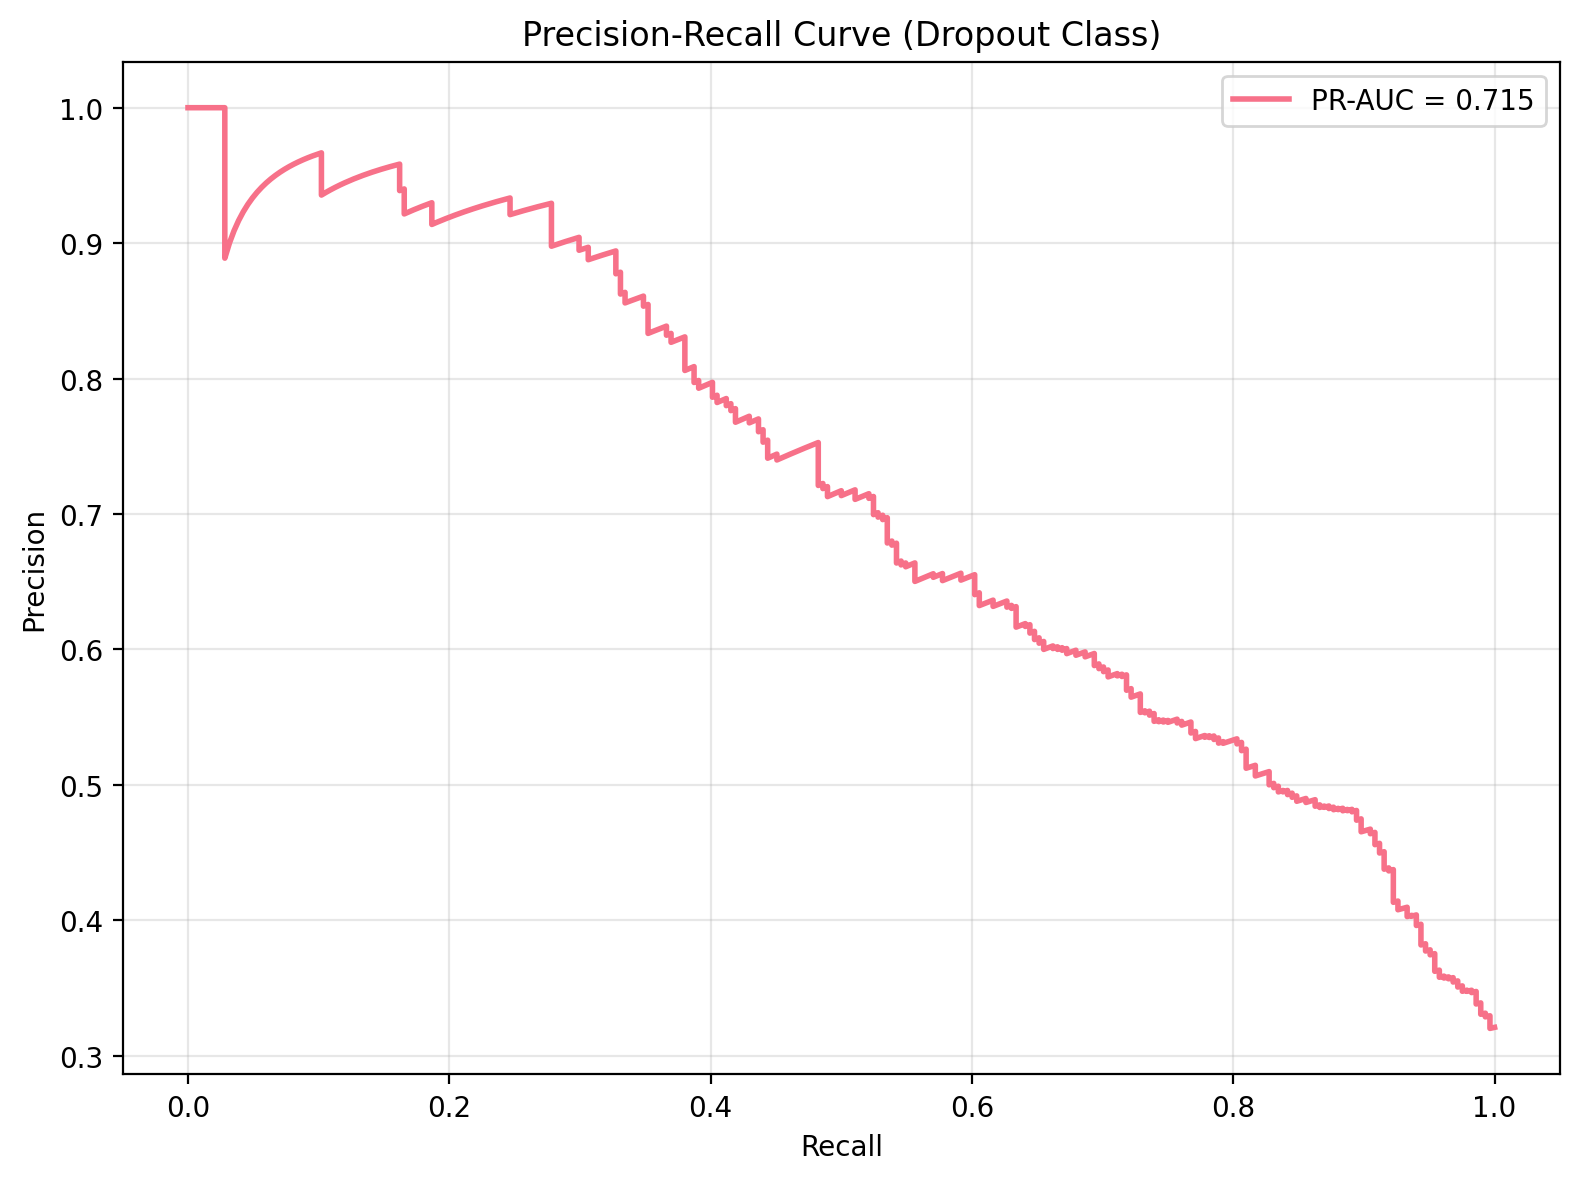

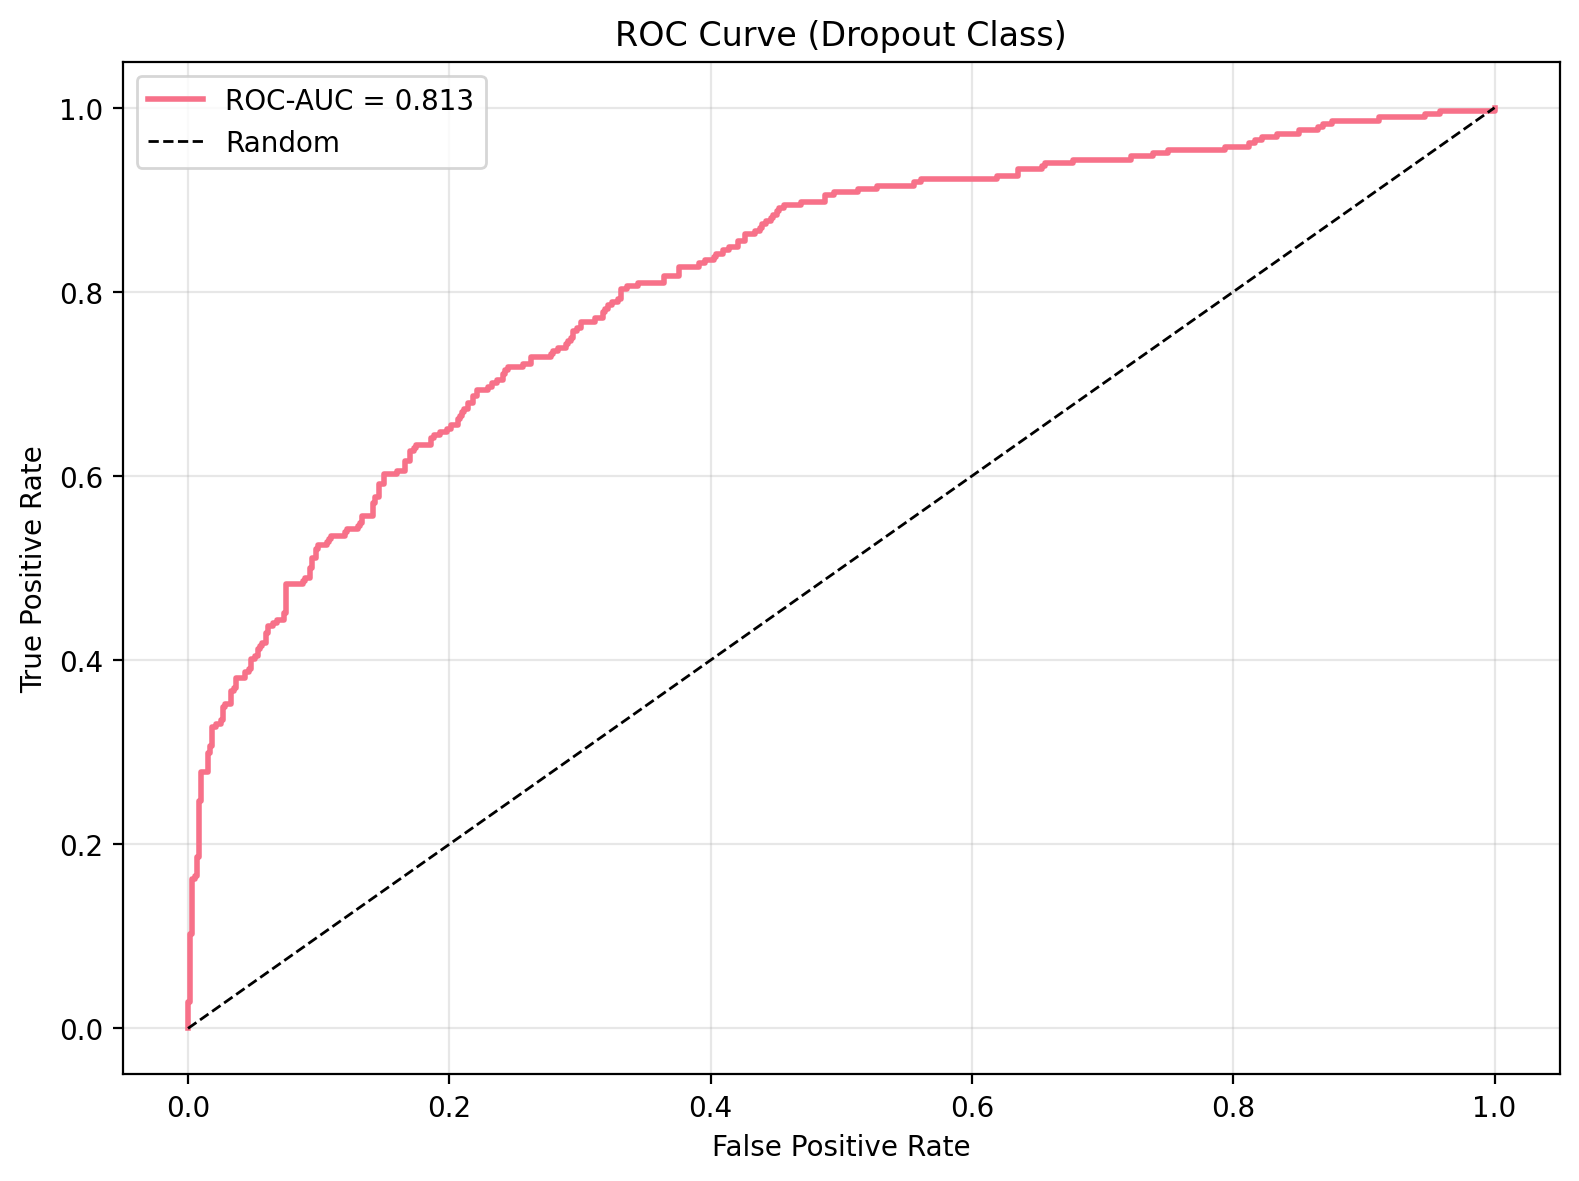

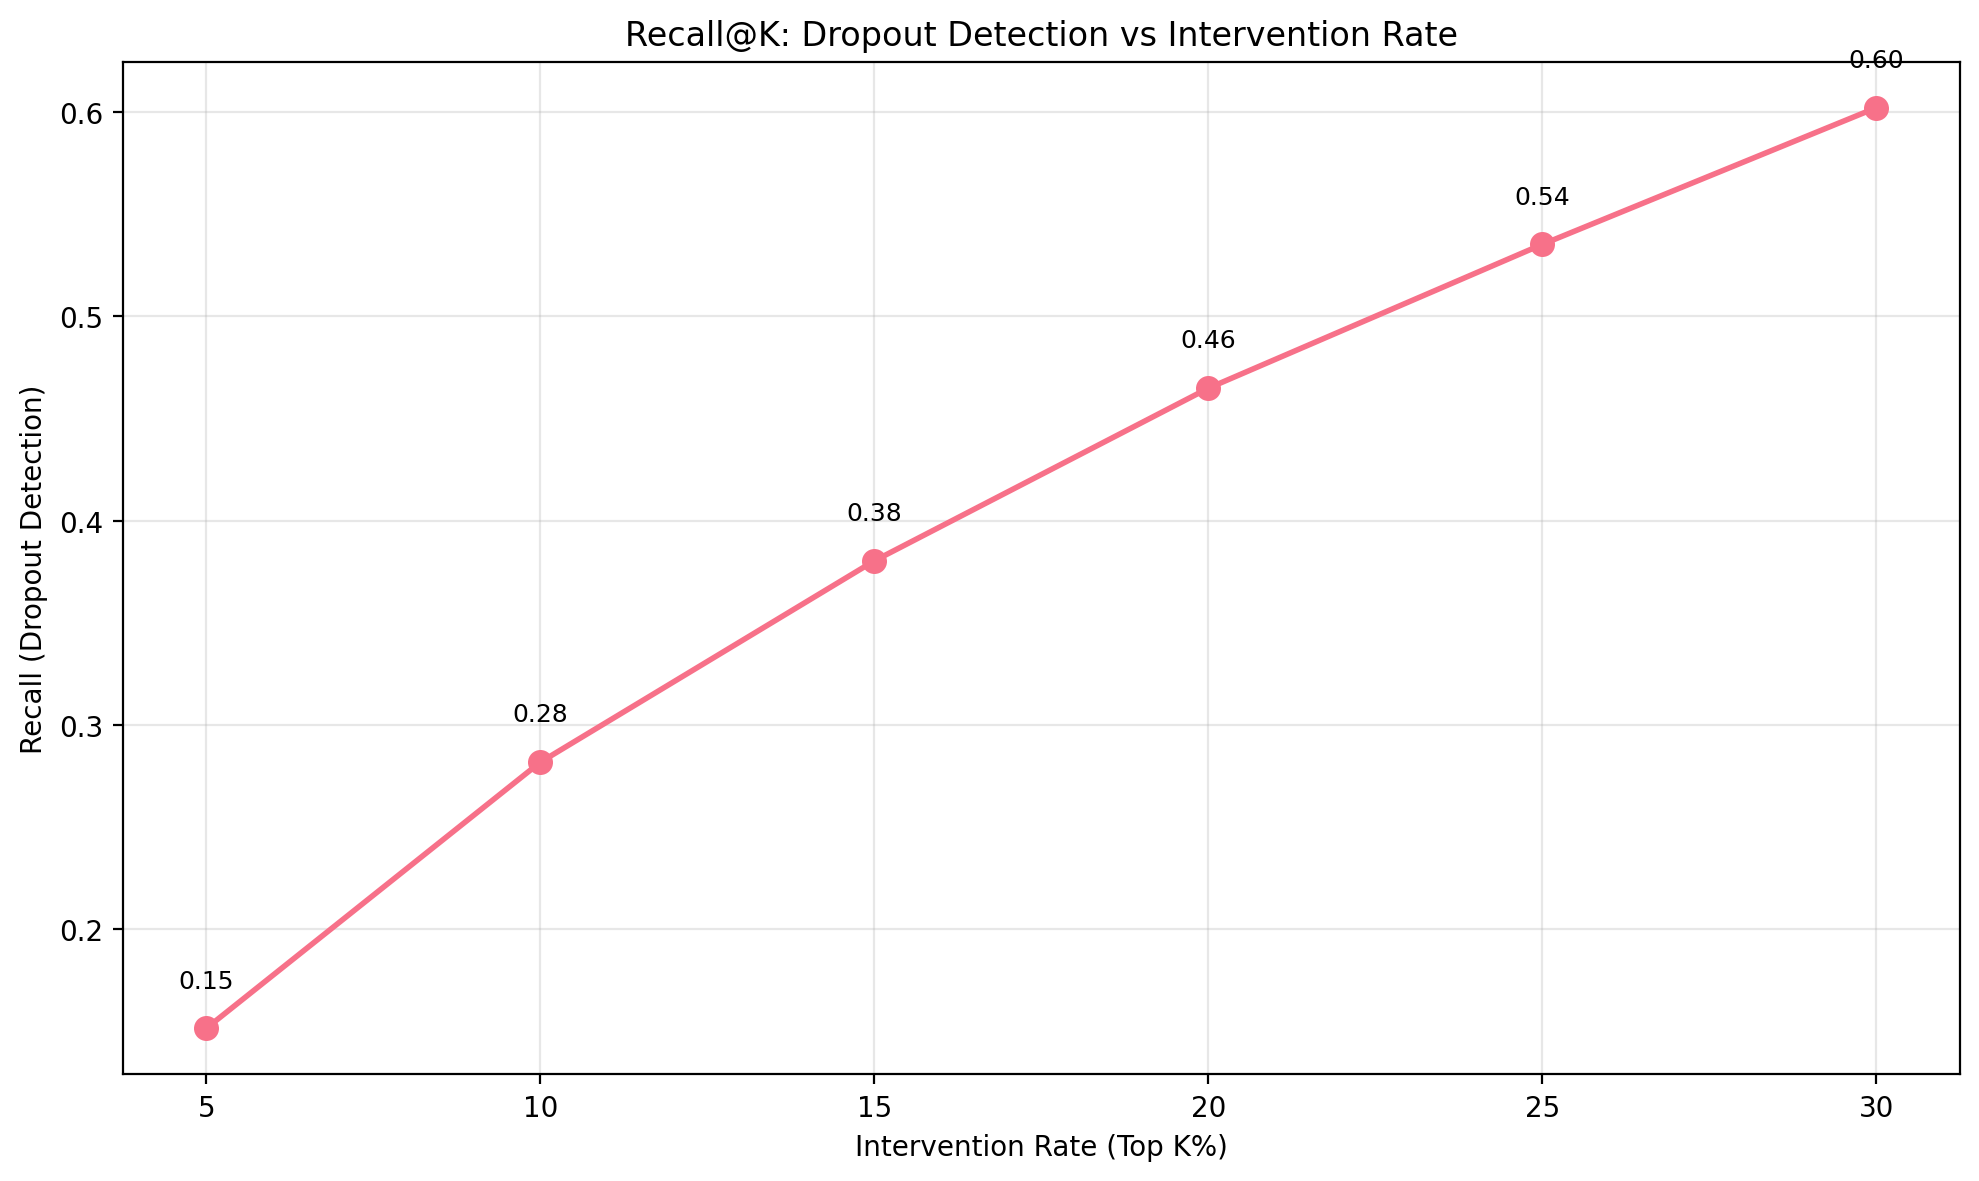

In [22]:
# Create evaluator
best_evaluator = RetentionEvaluator(best_model, X_test, y_test, class_names)

# Generate full evaluation report with plots
print("\nGenerating detailed evaluation for best enrollment model...")
metrics_df = best_evaluator.generate_report(dropout_class=dropout_idx, show_plots=True)

## 7. Feature Importance Analysis


Top 15 Most Important Features (Enrollment Phase):
                       feature  importance
       Tuition fees up to date    0.349209
            Scholarship holder    0.118597
                        Gender    0.041530
             Age at enrollment    0.035567
                        Course    0.033051
                        Debtor    0.031658
           Mother's occupation    0.031544
                           GDP    0.028528
    Daytime/evening attendance    0.028009
              Application mode    0.026986
                Inflation rate    0.025155
               Admission grade    0.024394
             Unemployment rate    0.023517
Previous qualification (grade)    0.023150
                     Displaced    0.022382


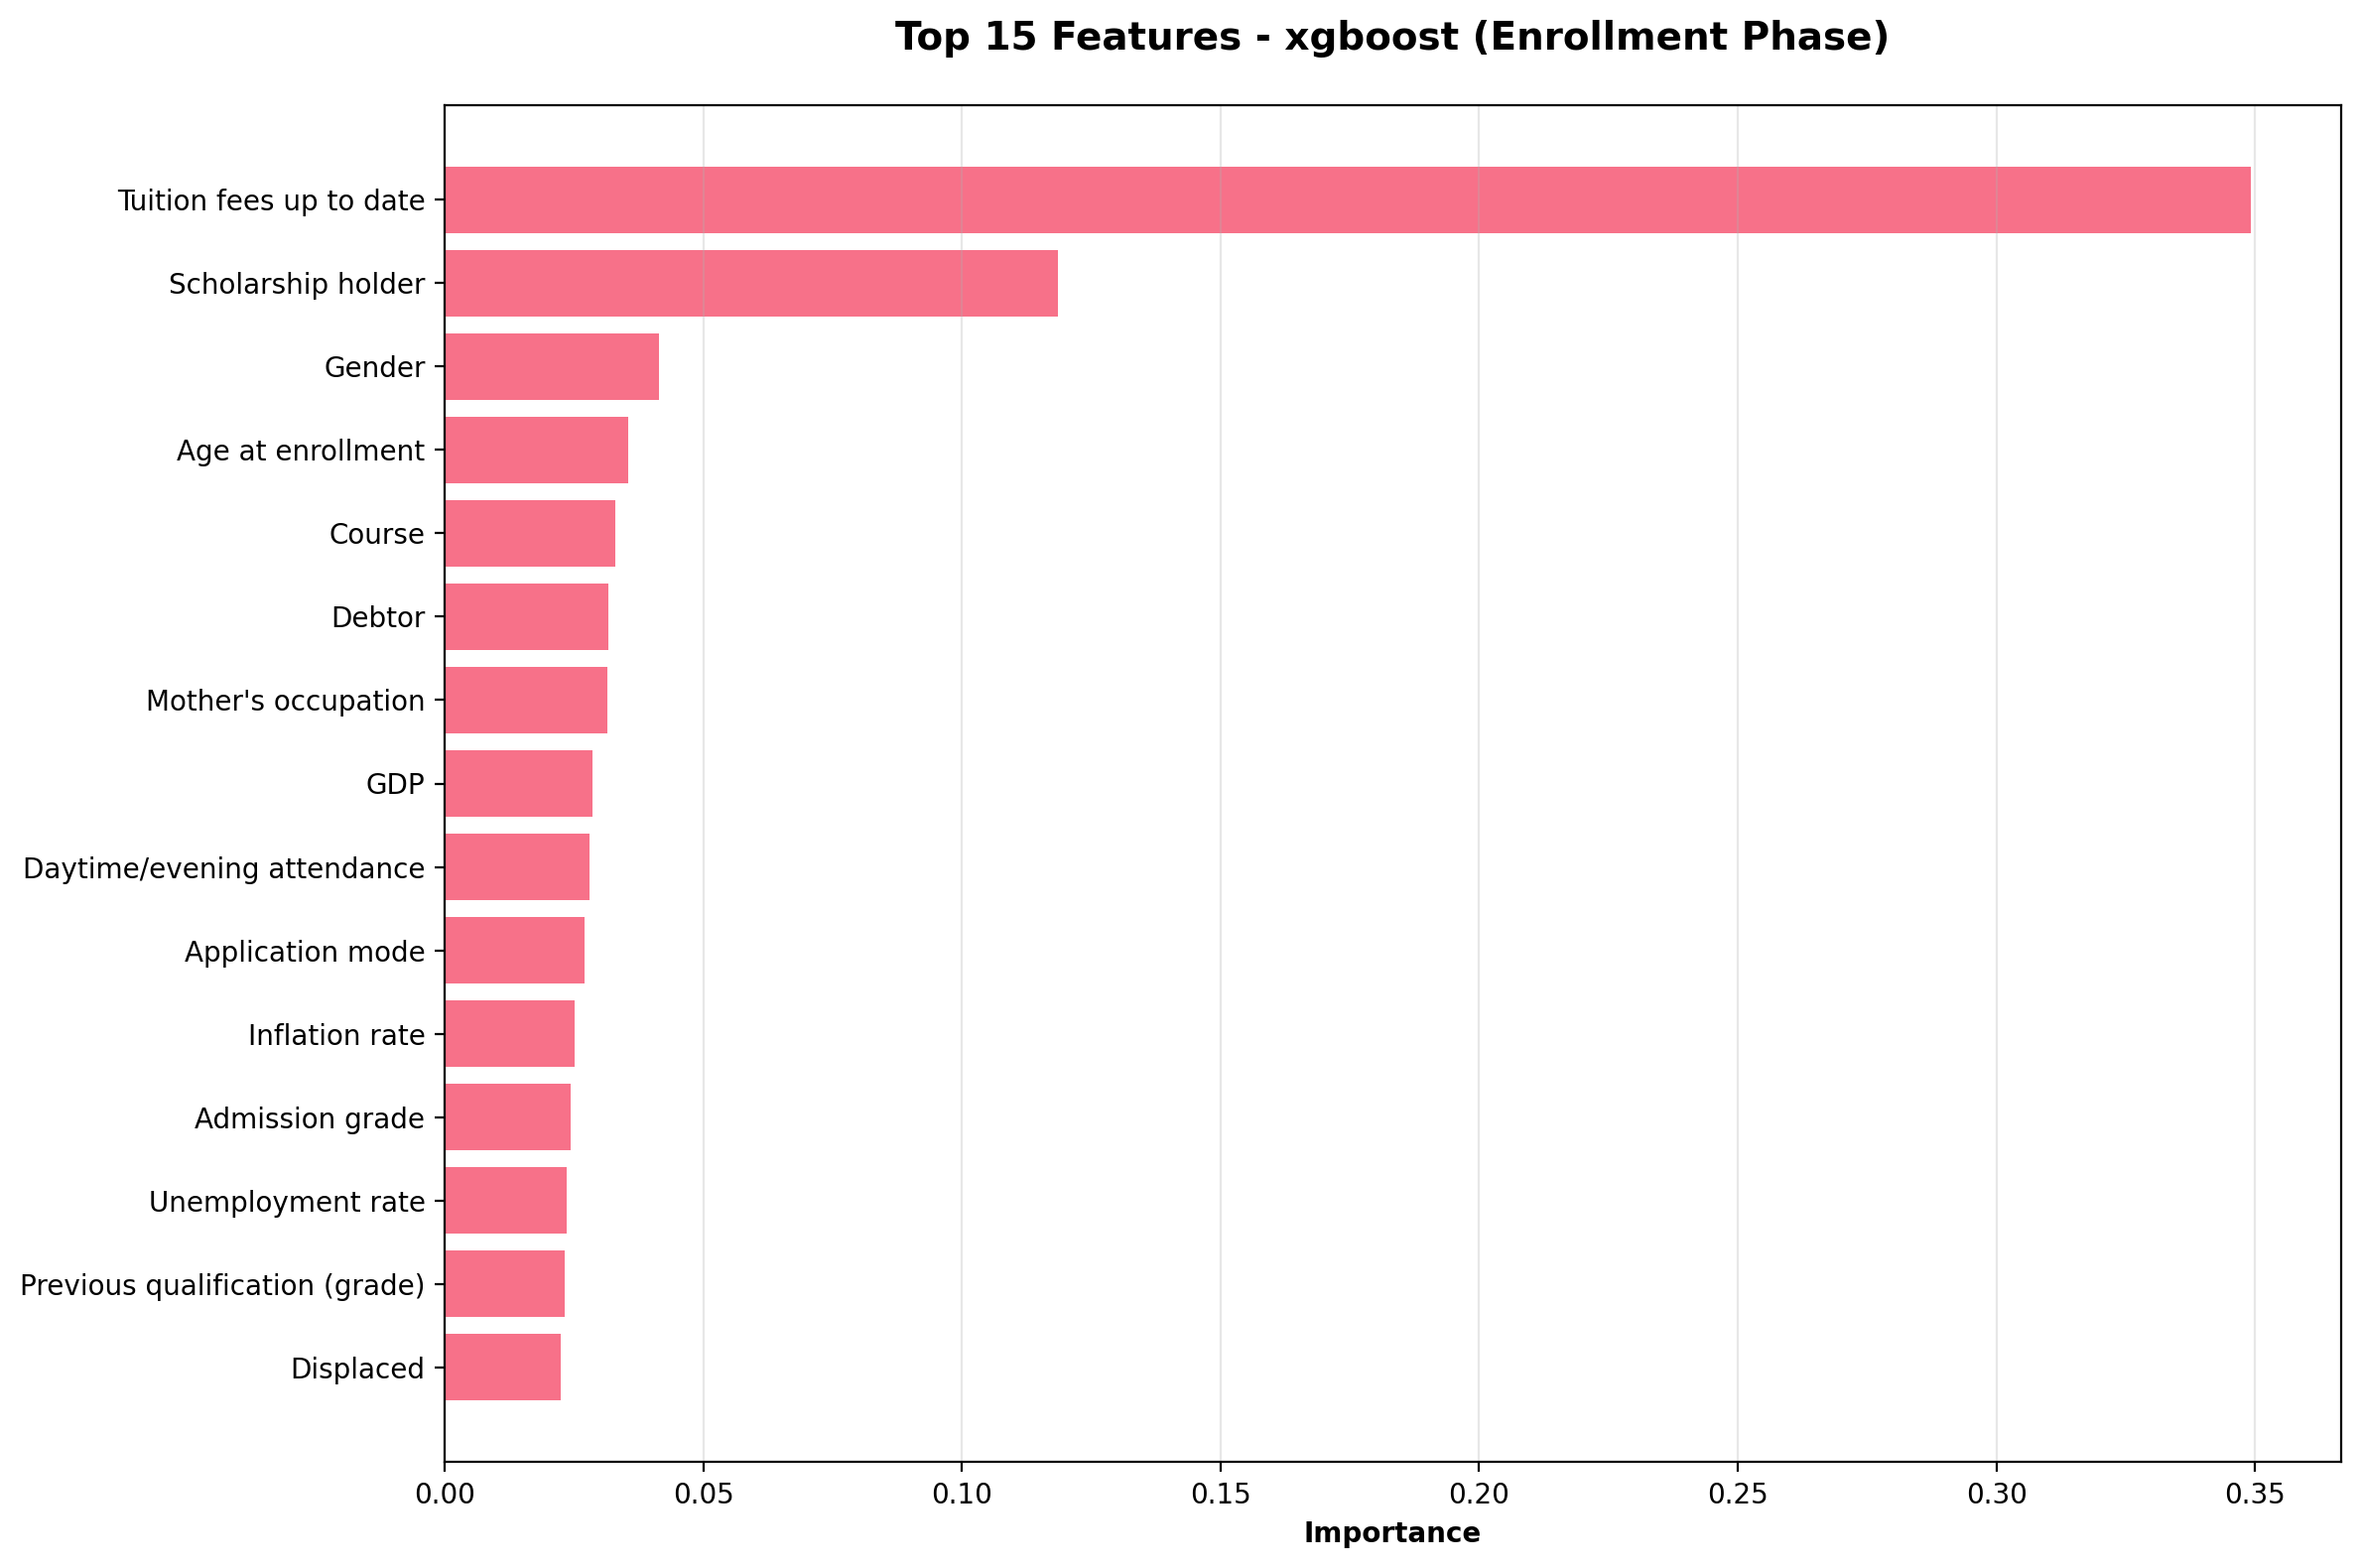


✓ Feature importance plot saved


In [23]:
# Feature importance for best model (if available)
if hasattr(best_model, 'feature_importances_'):
    features = get_features_for_phase('enrollment')
    importances = best_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 Most Important Features (Enrollment Phase):")
    print("="*60)
    print(importance_df.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontweight='bold')
    plt.title(f'Top 15 Features - {best_model_name} (Enrollment Phase)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../models/trained_models/feature_importance_enrollment.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Feature importance plot saved")
else:
    print(f"\nModel {best_model_name} does not support feature importance extraction.")

## Summary & Key Insights

### Training Summary
- **Models trained**: 3 (Logistic Regression, Random Forest, XGBoost)
- **Phases**: 3 (Enrollment, Semester 1, Semester 2)
- **Total models**: 9
- **Evaluation metric priority**: PR-AUC > Recall@K > ROC-AUC

### Key Findings
1. **Best overall model**: [Will be determined by results]
2. **Phase comparison**: Performance improves with more features (as expected)
3. **Enrollment phase**: Most valuable for early intervention
4. **Recall@10%**: Shows how many dropouts we catch with limited resources

### Operational Insights
- If advisors can help **10% of students**, the best enrollment model catches **XX%** of dropouts
- If we wait until **Semester 1**, we can catch **XX%** of dropouts
- Tradeoff: **Early intervention** (lower accuracy) vs **Late intervention** (higher accuracy)

### Next Steps
In the next notebook:
1. **Calibrate probabilities** for reliable risk scores
2. **Optimize thresholds** based on advisor capacity
3. **Final model selection** for deployment
4. **Discuss limitations** and ethical considerations